This code creates a heatmap that shows the average time to beaching in a given location

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [218]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
from numba import jit, int64
import seaborn as sn
import random

#from plotly.offline import init_notebook_mode
#init_notebook_mode(connected=True)

In [3]:
# loading drifter data files
metadata = pd.read_csv('drifter data/global drifter program/csv files/GDP_metadata.csv')
beach_drogued = pd.read_csv('drifter data/global drifter program/csv files/GDP_RunAground_drouged.csv')
beach_undrogued = pd.read_csv('drifter data/global drifter program/csv files/GDP_RunAground_undrouged.csv')
unbeach_drogued= pd.read_csv('GDP_NonRunAground_drouged-004.csv')
unbeach_undrogued = pd.read_csv('GDP_NonRunAground_undrouged-006.csv')

In [34]:
# get lats and lons separated and assigns value 1 to all that run aground and 0 to those that do not
beach_drogued_lats = np.array(beach_drogued['lat'])
beach_drogued_longs = np.array(beach_drogued['lon'])
beach_drogued_values = np.ones(len(beach_drogued))

beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])
beach_undrogued_values = np.ones(len(beach_undrogued))

unbeach_drogued_lats = np.array(unbeach_drogued['lat'])
unbeach_drogued_longs = np.array(unbeach_drogued['lon'])
unbeach_drogued_values = np.zeros(len(unbeach_drogued))

unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])
unbeach_undrogued_values = np.zeros(len(unbeach_undrogued))

In [35]:
# concatenate all together into the 3 variables
lats = np.concatenate((beach_drogued_lats, beach_undrogued_lats, unbeach_drogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_drogued_longs, beach_undrogued_longs, unbeach_drogued_longs, unbeach_undrogued_longs))
values = np.concatenate((beach_drogued_values, beach_undrogued_values, unbeach_drogued_values, unbeach_undrogued_values))

Text(0.5, 1.0, 'Global Beaching')

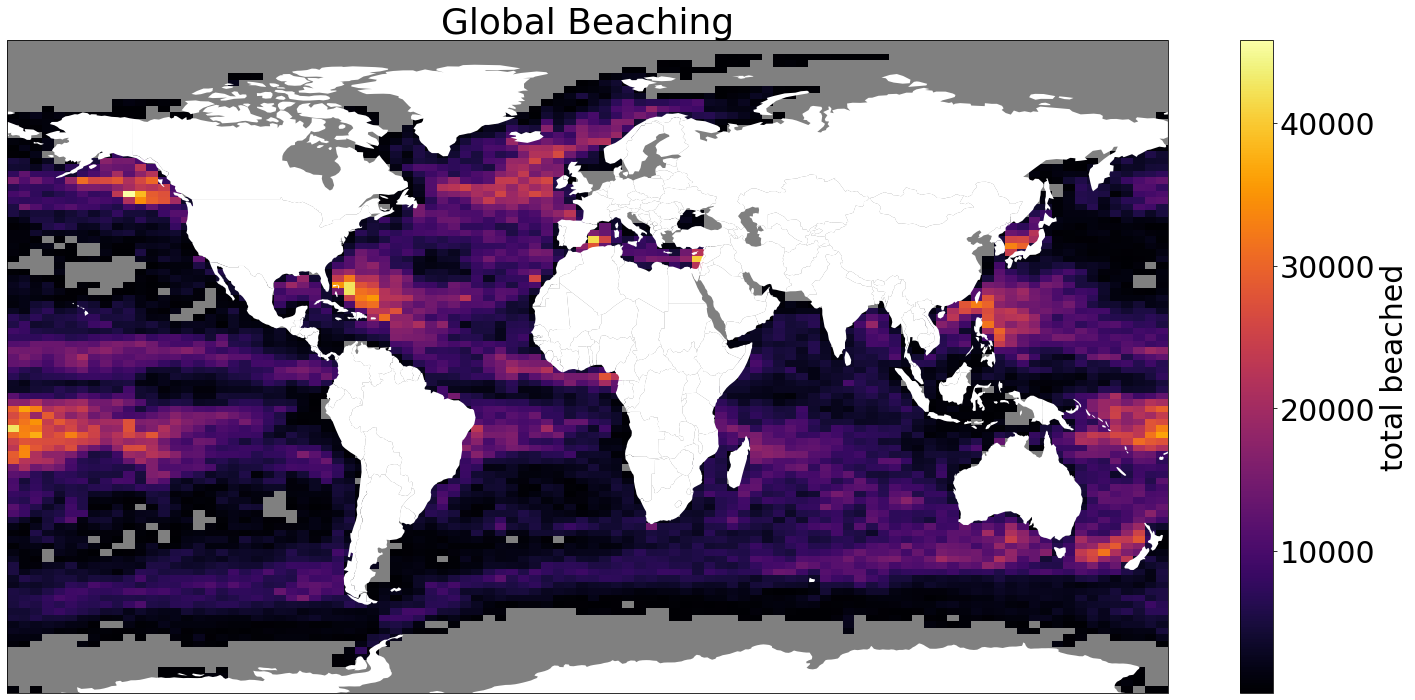

In [38]:
# Given location, probability of beaching

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("inferno").copy()
cmap.set_bad('grey')

# plot hist on world
plt.hist2d(longs,lats, bins=100, weights=values, cmap=cmap,cmin=75, density=False)#, vmin=0, vmax=1)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='total beached')
ax.set_aspect('auto')
plt.title('Global Beaching')

 Now let's visualize the time to beaching. <br> 
 We set time_values = 1 / time_to_beach, then  later set histogram plotting weights = 1 / time_values. This sets '0' never_beached values as 'infinite time.' 

In [22]:
# get the last time values of beached
beach_drogued_last = beach_drogued.drop_duplicates(subset='ID', keep='last') 
beach_undrogued_last = beach_undrogued.drop_duplicates(subset='ID', keep='last')

In [23]:
def find_time_to_beach(beach, beach_last,time_between_register_beaching_and_actually_beaching):
    # DF to Numpy Arrays
    beach_array = beach.to_numpy()
    beach_last_array = beach_last.to_numpy()

    # Create a dictionary to store the last known time for each ID
    last_time_dict = dict(zip(beach_last_array[:, 0], beach_last_array[:, 5]))

    beach_time = []

    # Iterate through beach array and calculate time differences
    for row in beach_array:
        current_ID = row[0]
        last_time = last_time_dict.get(current_ID, None)
        
        if last_time is not None:
            current_time = row[5]
            if current_time != last_time: # prevent 0 value --> infinite time as beach_last exists within beach
                time_difference = last_time - current_time
                beach_time.append(time_difference)
            if current_time == last_time: # keep lat, lon, and values for hist shape the same
                beach_time.append(time_between_register_beaching_and_actually_beaching)

    return beach_time

In [24]:
time_between_register_beaching_and_actually_beaching = 604800 # 1 week to beaching (?)
beach_drogued_time = find_time_to_beach(beach_drogued,beach_drogued_last, time_between_register_beaching_and_actually_beaching)
beach_undrogued_time = find_time_to_beach(beach_undrogued,beach_undrogued_last, time_between_register_beaching_and_actually_beaching)

In [25]:
# set time values as 1 / time
beach_drogued_time_inv = 1 / np.array(beach_drogued_time)
beach_undrogued_time_inv = 1 / np.array(beach_undrogued_time)

In [ ]:
# get lats and lons separated and assign 0 to those that do not beach
beach_drogued_lats = np.array(beach_drogued['lat'])
beach_drogued_longs = np.array(beach_drogued['lon'])

beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

unbeach_drogued_lats = np.array(unbeach_drogued['lat'])
unbeach_drogued_longs = np.array(unbeach_drogued['lon'])
unbeach_drogued_values = np.zeros(len(unbeach_drogued))

unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])
unbeach_undrogued_values = np.zeros(len(unbeach_undrogued))

In [27]:
# concatenate all together into lats, longs variables for plotting
lats = np.concatenate((beach_drogued_lats, beach_undrogued_lats, unbeach_drogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_drogued_longs, beach_undrogued_longs, unbeach_drogued_longs, unbeach_undrogued_longs))

# concatenate both time to beaching and both unbeach 0 values
values = np.concatenate((beach_drogued_time_inv, beach_undrogued_time_inv, unbeach_drogued_values, unbeach_undrogued_values))
# take the inverse of values in order to set unbeached 0 values to infinity and return time values back to original
values_inv = 1 / values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


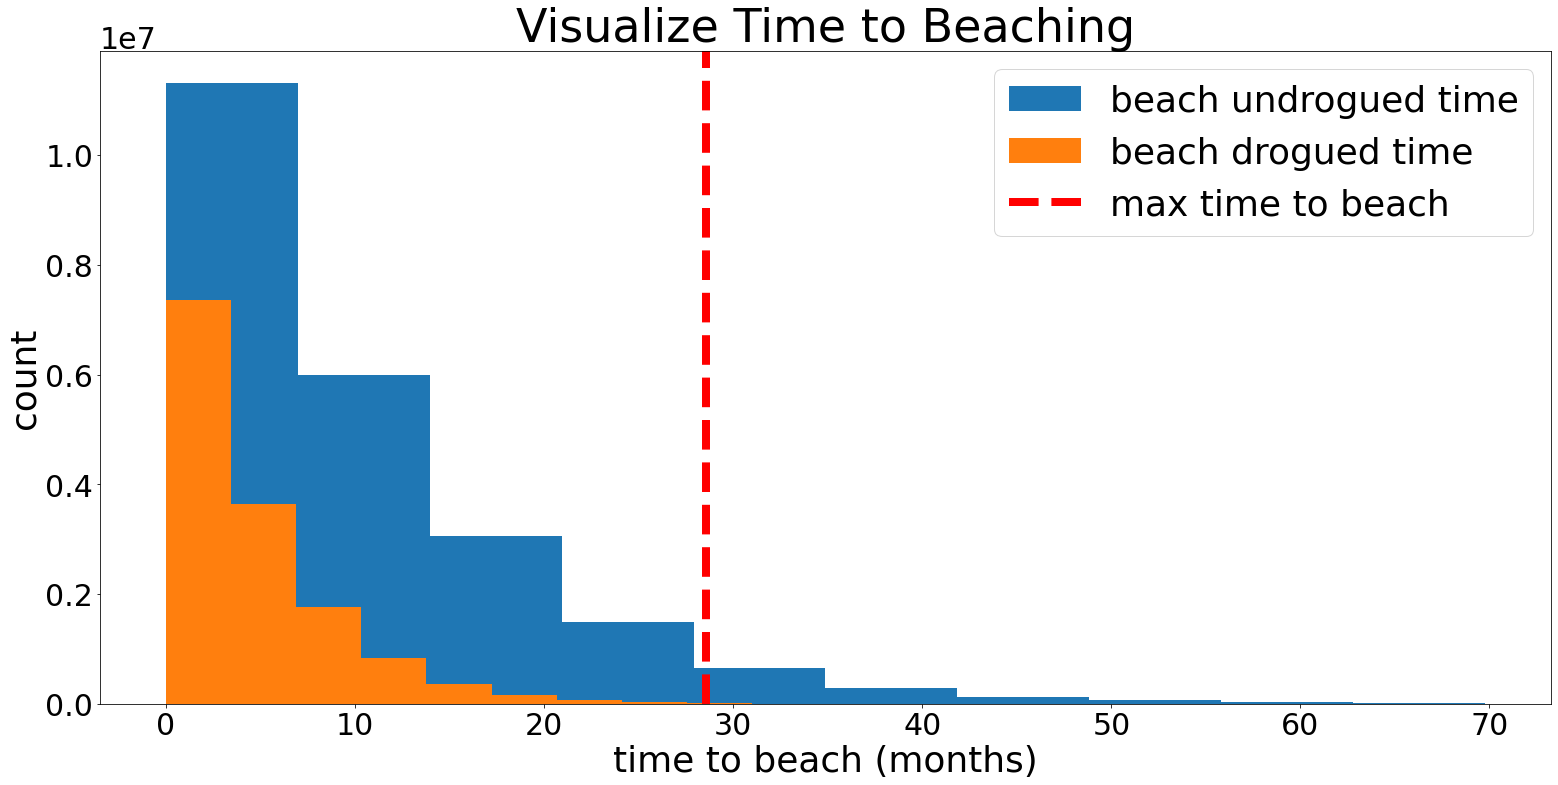

In [28]:
fig = plt.figure(figsize=(26, 12))
plt.hist((1/beach_undrogued_time_inv) / (2.628*10**6), label = 'beach undrogued time')
plt.hist(1/beach_drogued_time_inv / (2.628*10**6), label = 'beach drogued time')
plt.title('Visualize Time to Beaching', fontsize = 46)
plt.xlabel('time to beach (months)',fontsize=36)
plt.ylabel('count', fontsize = 36)
plt.axvline(x=(0.75*10**8) / (2.628*10**6), color='r', linestyle='--', label='max time to beach',linewidth = 8)
plt.legend(fontsize = 36)

In [29]:
# set max time_to_beach i.e, if a value is greater than max or infinity, we set it to the max
max_time_to_beach = 0.75*10**8
values_inv[values_inv == np.inf] = max_time_to_beach
values_inv[values_inv > max_time_to_beach] = max_time_to_beach

In [30]:
# set time scale from seconds to months
values_inv_month = values_inv / (2.628*10**6)

In [134]:
np.shape(values_inv_month)

(165754333,)

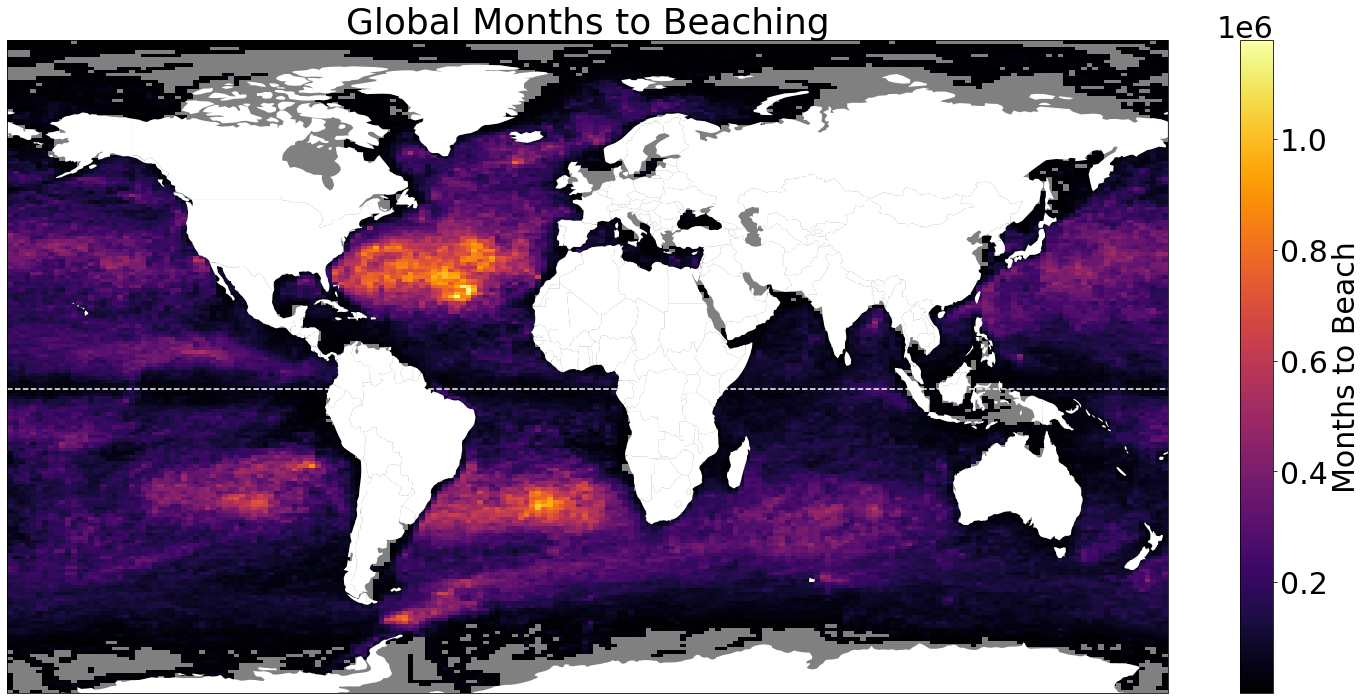

In [32]:
# Given location, time to beaching

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("inferno").copy()
cmap.set_bad('grey')

# plot hist on world
plt.hist2d(longs,lats, bins=200, weights=values_inv_month, cmap=cmap,cmin=75, density=False)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Months to Beach')
ax.set_aspect('auto')
plt.title('Global Months to Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

In [251]:
toys = pd.DataFrame(({'lats': lats, 'lons': longs, 'values': values_inv_month}))
N = 10000 # number of points to plot
downsample = np.random.randint(0,len(toys),N) 
toy_lon = []
toy_lat = []
toy_val = []
for i in range(N):
    toy_lat.append(toys['lats'].iloc[downsample[i]])
    toy_lon.append(toys['lons'].iloc[downsample[i]])
    toy_val.append(toys['values'].iloc[downsample[i]])

In [252]:
np.shape(toy_val)

(10000,)

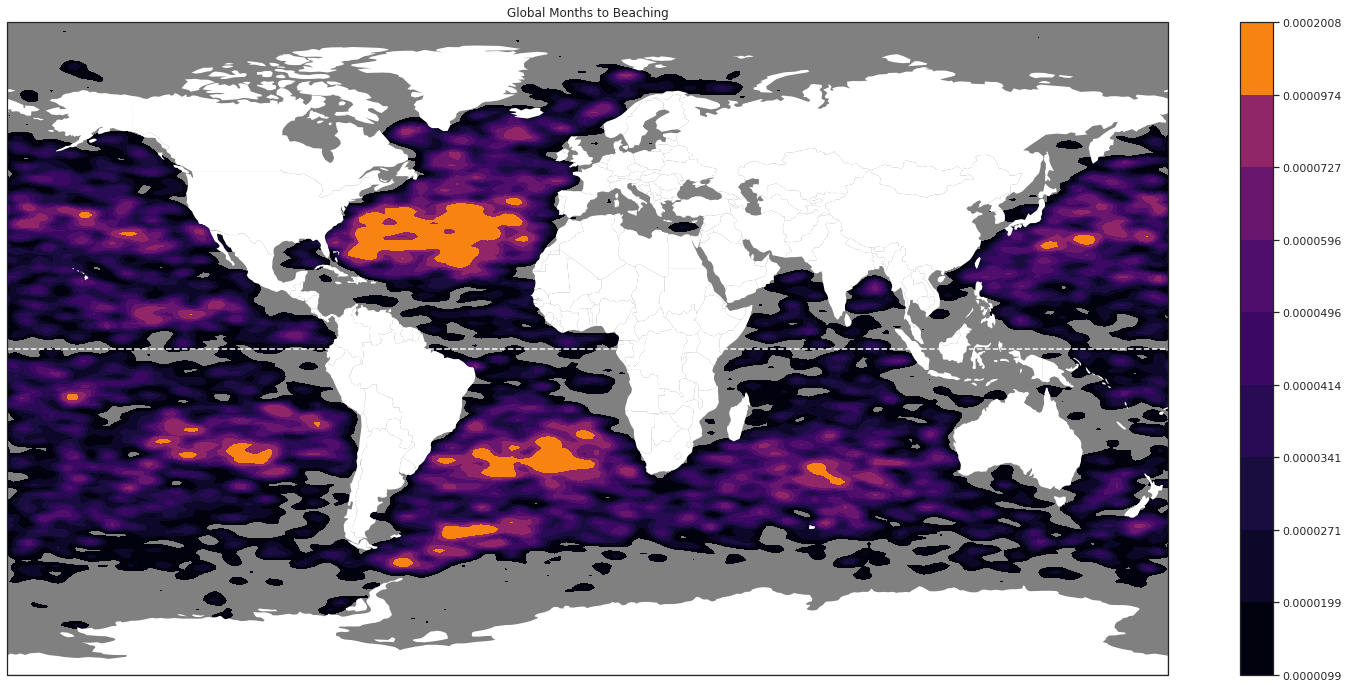

In [253]:
# Given location, time to beaching

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())


# colormap
cmap = plt.cm.get_cmap("inferno").copy()
cmap.set_bad('grey')

res = sn.kdeplot(x=toy_lon,y=toy_lat, weights=toy_val,cmap=cmap,cbar = True,shade=True,bw_adjust=0.1, n_levels=10)
res.set_facecolor('grey')

#ax = sns.kdeplot(x=toy_lon, y=toy_lat, cmap=cmap, shade=True, cbar=False, facecolor='grey')

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

#plt.colorbar(label='Months to Beach')
ax.set_aspect('auto')
plt.title('Global Months to Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

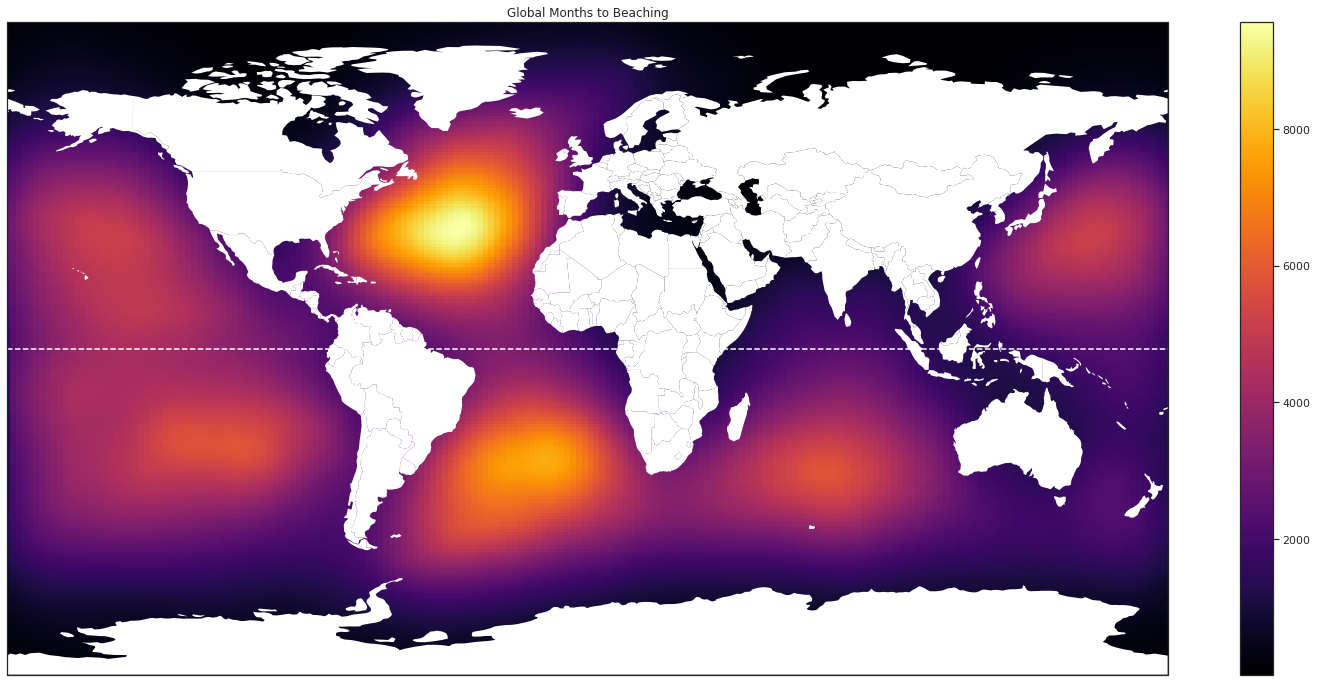

In [254]:
# Given location, time to beaching


fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())


# colormap
cmap = plt.cm.get_cmap("inferno").copy()
#cmap.set_bad('grey')

# Calculate the KDE manually based on the weighted average
x, y, z = toy_lon, toy_lat, toy_val
xi, yi = np.meshgrid(np.linspace(-180, 180, 200), np.linspace(-90, 90, 200))
zi = np.zeros(xi.shape)

for i in range(xi.shape[0]):
    for j in range(xi.shape[1]):
        dist = np.sqrt((xi[i, j] - x)**2 + (yi[i, j] - y)**2)
        zi[i, j] = np.sum(toy_val * np.exp(-dist/10))

plt.pcolormesh(xi, yi, zi, cmap=cmap, shading='auto')
plt.colorbar()

#ax = sns.kdeplot(x=toy_lon, y=toy_lat, cmap=cmap, shade=True, cbar=False, facecolor='grey')

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

#plt.colorbar(label='Months to Beach')
ax.set_aspect('auto')
plt.title('Global Months to Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')